In [1]:
import torch
from torch import nn
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE



In [2]:
class MyModel(nn.Module):
    def __init__(self, params: dict):
        super(MyModel, self).__init__()
        self.params = params

        self.embeddings = nn.Embedding(
            params['vocab_size'],
            params['embed_size']
        )
        self.pe = self._generate_positional_encodings().to(params['device']) # (seq_len, embed_size) pe is not a param so must be sent to device manually
        self.transformers = nn.ModuleList([
            Transformer(params) for _ in range(params['num_transformers'])
        ])
        self.ff = nn.Sequential(
            nn.Linear(params['embed_size'], params['vocab_size']),
        )
        total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print('Model init with device: ', params['device'])
        #print total params with 000, formatting
        print(f'Total params: {total_params:,}')

    def forward(self, x: torch.Tensor, mask=None) -> torch.Tensor:
        batch_size = self.params['batch_size']
        seq_len = self.params['seq_len']
        embed_size = self.params['embed_size']
        vocab_size = self.params['vocab_size']

        # x: (batch_size, seq_len)
        x = self.embeddings(x) # x: (batch_size, seq_len, embed_size)
        # mask = mask.unsqueeze(-1)
        # mask = mask.expand_as(x) # mask: (batch_size, seq_len, embed_size)
        x += self.pe
        assert x.shape == (batch_size, seq_len, embed_size), f'failed x shape; {x.shape}, and should be {(batch_size, seq_len, embed_size)}'

        # transformers
        for transformer in self.transformers:
            x = transformer(x)
        assert x.shape == (batch_size, seq_len, embed_size), f'failed x shape; {x.shape}, and should be {(batch_size, seq_len, embed_size)}'
        
        # projection to vocab size
        x = self.ff(x)
        #pooling (batch size, vocab size)
        x = torch.mean(x, dim=1)

        assert x.shape == (batch_size, vocab_size), f'failed x shape; {x.shape}, and should be {(batch_size, vocab_size)}'
        return x

    def _generate_positional_encodings(self):
        seq_len = self.params['seq_len']
        embed_size = self.params['embed_size']
        # Initialize positional encoding matrix
        pos_encodings = torch.zeros(seq_len, embed_size)
        # Generate encoding for each position
        for pos in range(seq_len):
            for i in range(0, embed_size, 2):
                pos_encodings[pos, i] = math.sin(pos / 10000 ** (i / embed_size))
                if i + 1 < embed_size:  # Ensure index is in range
                    pos_encodings[pos, i + 1] = math.cos(pos / 10000 ** ((i + 1) / embed_size))
        assert pos_encodings.shape == (seq_len, embed_size), f'failed in positional encoding shape {pos_encodings.shape}, and should be {(seq_len, embed_size)}'
        return pos_encodings

class Transformer(nn.Module):
    def __init__(self, params: dict):
        super(Transformer, self).__init__()
        self.params = params
        
        # attention
        self.q_w = nn.Parameter(torch.randn(params['embed_size'], params['embed_size']))
        self.k_w = nn.Parameter(torch.randn(params['embed_size'], params['embed_size']))
        self.v_w = nn.Parameter(torch.randn(params['embed_size'], params['embed_size']))
        self.linear_out = nn.Linear(params['embed_size'], params['embed_size'])
        self.ln = nn.LayerNorm(params['embed_size'])

        # feedforward network
        self.ff = nn.Sequential(
            nn.Linear(params['embed_size'], params['hidden_size']),
            nn.GELU(),
            nn.Linear(params['hidden_size'], params['embed_size'])
        )
        self.ln2 = nn.LayerNorm(params['embed_size'])
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size = self.params['batch_size']
        seq_len = self.params['seq_len']
        embed_size = self.params['embed_size']
        n_heads = self.params['n_heads']
        head_dim = embed_size // n_heads

        q = x @ self.q_w # q: (batch_size, seq_len, num_heads*head_dim)
        k = x @ self.k_w
        v = x @ self.v_w
        assert q.shape == (batch_size, seq_len, embed_size), f'failed in q shape {q.shape}, and should be {(batch_size, seq_len, embed_size)}'
        #check for nan values
        assert not torch.isnan(q).any(), 'q has nan values'
        assert not torch.isnan(k).any(), 'k has nan values'
        assert not torch.isnan(v).any(), 'v has nan values'

        # attention scores
        q = q.view(batch_size, seq_len, n_heads, head_dim) # q: (batch_size, seq_len, num_heads, head_dim)
        k = k.view(batch_size, seq_len, n_heads, head_dim)
        v = v.view(batch_size, seq_len, n_heads, head_dim)
        assert q.shape == (batch_size, seq_len, n_heads, head_dim), f'failed in q shape {q.shape}, and should be {(batch_size, seq_len, n_heads, head_dim)}'
        
        # b = batch q,k = seq_len, h = n_heads, d = head_dim
        # multiply q (seq_len * head_dim) @ k (head_dim * seq_len) =>  seq_len * seq_len
        scores = torch.einsum('bqhd,bkhd->bhqk', [q, k])
        assert scores.shape == (batch_size, n_heads, seq_len, seq_len), f'failed in scores shape {scores.shape}, and should be {(batch_size, n_heads, seq_len, seq_len)}'
        
        # mask and softmax
        scores = torch.nn.functional.softmax(scores, dim=-1)
        # assert that sums to one, this sometimes fails due to nan values
        # assert round(sum(scores[0][0][0]).item(),2)  == 1, f'failed in sum of scores {sum(scores[0][0][0])}, and should be {1}'
        
        # scores shape: (batch_size, n_heads, seq_len, seq_len)
        # v shape:      (batch_size, seq_len, n_heads, head_dim) 
        # batch_size , n _head are independant
        # multiplication is therefore scores(seq_len, seq_len) @ v(seq_len, head_dim) => (seq_len, head_dim)
        out = torch.einsum('bhqk,bkhd->bqhd', [scores, v])
        assert out.shape == (batch_size, seq_len, n_heads, head_dim), f'failed in out shape {out.shape}, and should be {(batch_size, seq_len, n_heads, head_dim)}'

        # Reshape back to 3 dimensions: (batch_size, seq_len, embed_size)
        out = out.reshape(batch_size, seq_len, -1)
        assert out.shape == (batch_size, seq_len, embed_size), f'failed in out shape {out.shape}, and should be {(batch_size, seq_len, embed_size)}'

        # linear proj, residual, layer norm
        out = self.linear_out(out)
        out = out + x
        out = self.ln(out)

        # feedforward
        out = self.ff(out)
        out = out + x # residual
        out = self.ln2(out)
        assert out.shape == (batch_size, seq_len, embed_size), f'failed in out shape {out.shape}, and should be {(batch_size, seq_len, embed_size)}'
        return out
    


In [3]:
params = {
    'epochs': 1,
    'batch_size': 200,
    'num_transformers': 4, # number of transformer layers
    'seq_len': 45,
    'vocab_size': 30522,
    'embed_size': 256 ,
    'n_heads': 8,
    'output_dim': 30522,
    'hidden_size': 256, # feedforward network hidden size
    'learning_rate': 0.000001,
    'weight_decay': 0.0001,
    'patience': 4,
    'device': 'cpu'

}
model = MyModel(params)
model.load_state_dict(torch.load('best_model_3.pth', map_location=params['device']))


Model init with device:  cpu
Total params: 17,237,818


<All keys matched successfully>

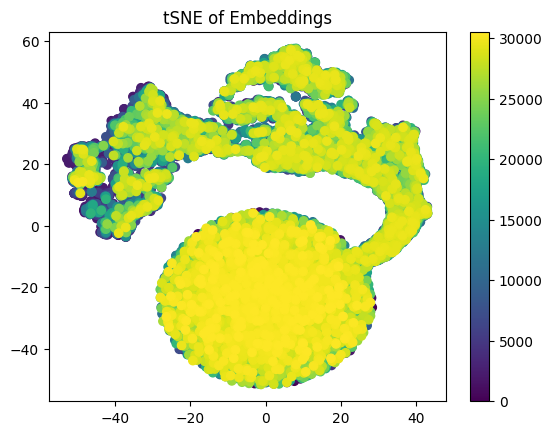

In [4]:
def plot_embeddings(embeddings, labels, reduction_type='PCA'):
    if reduction_type == 'PCA':
        pca = PCA(n_components=2)
        reduced_data = pca.fit_transform(embeddings)
    elif reduction_type == 'tSNE':
        tsne = TSNE()
        reduced_data = tsne.fit_transform(embeddings)
        
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels)
    plt.colorbar()
    plt.title(f'{reduction_type} of Embeddings')
    plt.show()


embeddings = model.embeddings.weight.data.cpu().numpy()
labels = np.arange(params['vocab_size']) 


plot_embeddings(embeddings, labels, reduction_type='tSNE')


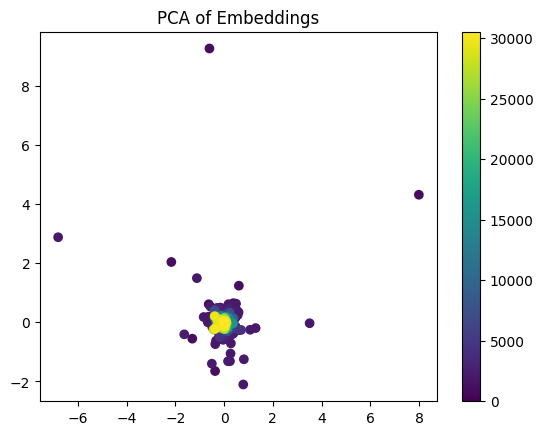

In [5]:
plot_embeddings(embeddings, labels, reduction_type='PCA')

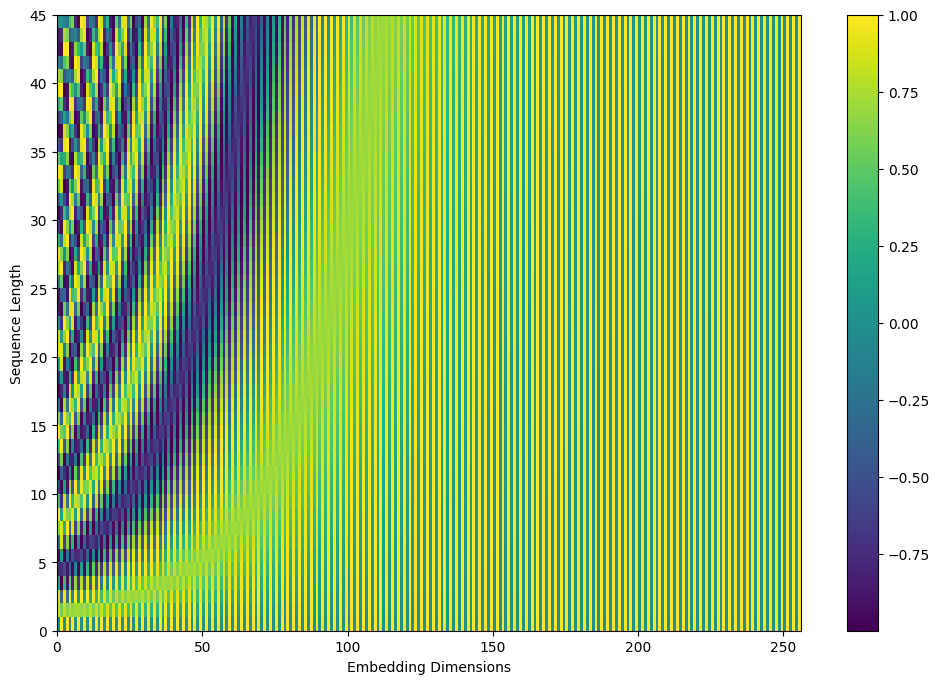

In [6]:
def plot_positional_encodings(pe):
    plt.figure(figsize=(12, 8))
    
    # Directly plot the 2D positional encodings
    plt.pcolormesh(pe, cmap='viridis')
    plt.xlabel('Embedding Dimensions')
    plt.ylabel('Sequence Length')
    plt.colorbar()
    plt.show()

pe = model.pe.data.numpy()
plot_positional_encodings(pe)



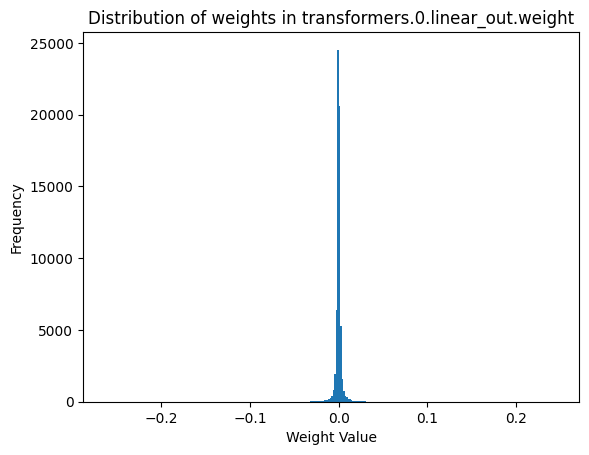

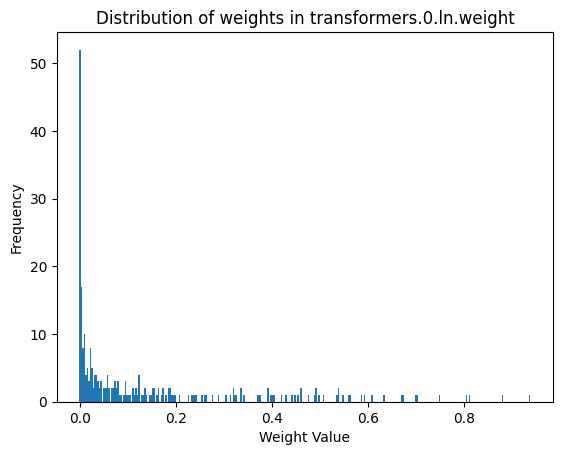

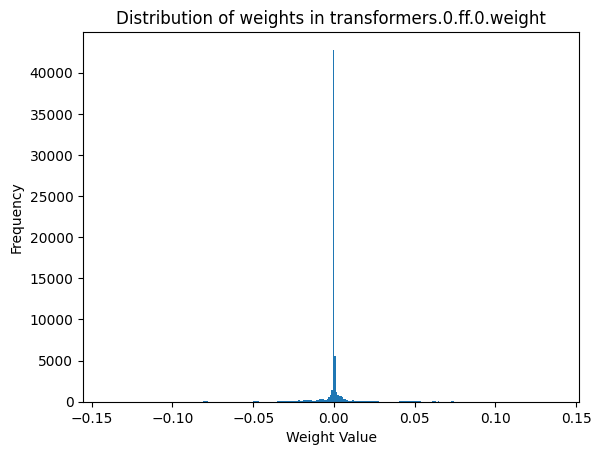

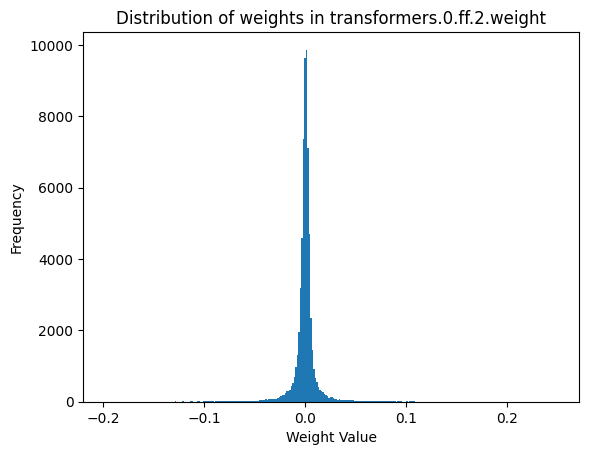

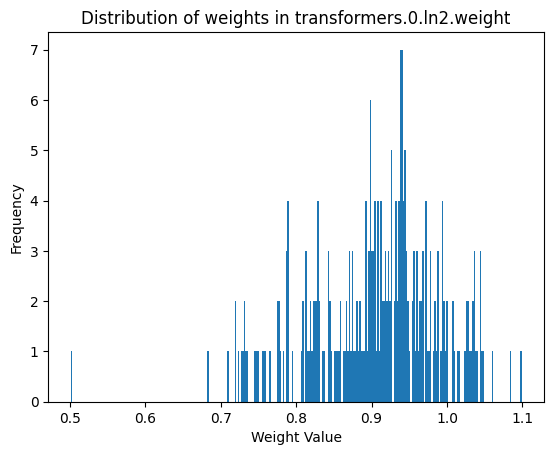

In [7]:
def plot_weight_distribution(model, layer_name):
    for name, param in model.named_parameters():
        if layer_name in name and "weight" in name:
            weights = param.data.cpu().numpy().flatten()
            plt.hist(weights, bins=300)
            plt.title(f'Distribution of weights in {name}')
            plt.xlabel('Weight Value')
            plt.ylabel('Frequency')
            plt.show()

# Example: Plot weight distribution for the first Transformer layer
plot_weight_distribution(model, 'transformers.0')


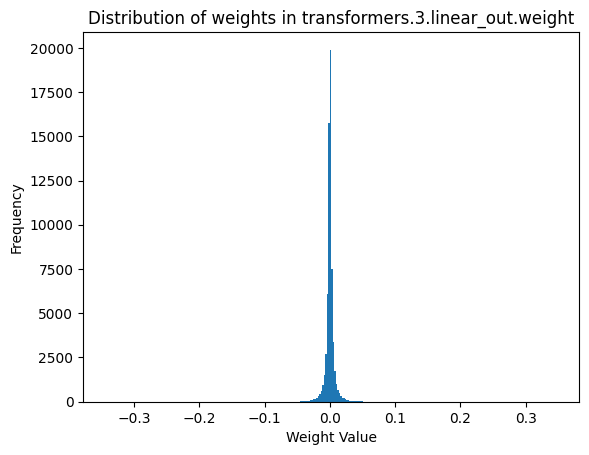

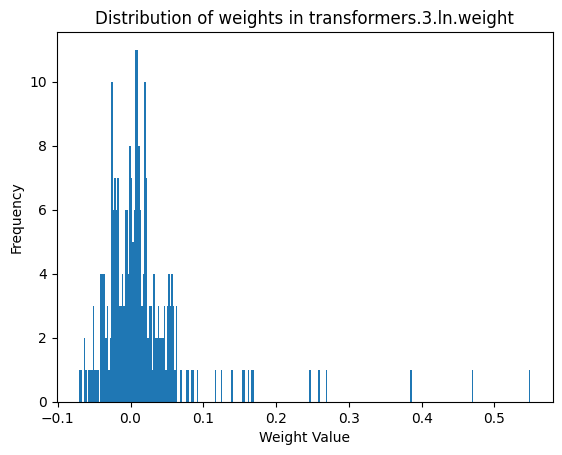

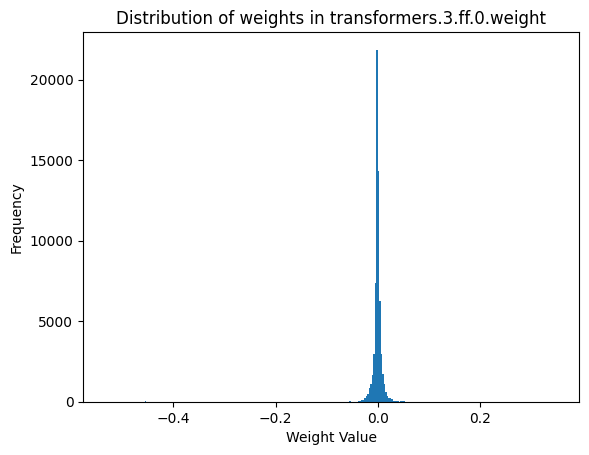

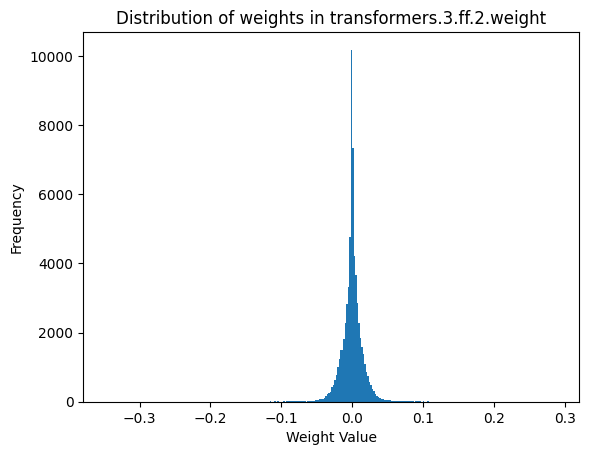

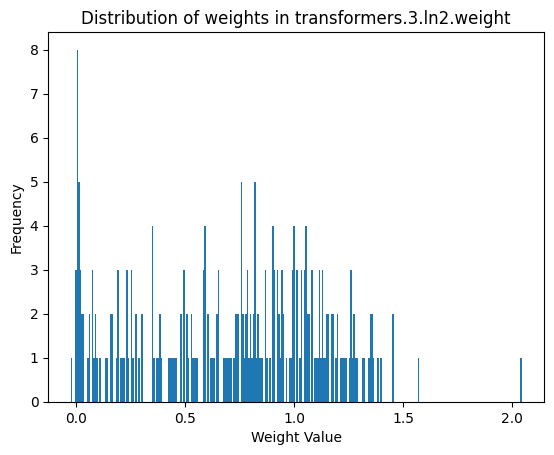

In [8]:
plot_weight_distribution(model, 'transformers.3')

In [9]:
def plot_attention_heatmap(attention_matrix):
    plt.imshow(attention_matrix)
    plt.title('Attention Heatmap')
    plt.xlabel('Keys')
    plt.ylabel('Queries')
    plt.colorbar()
    plt.show()

# You'll need to compute the attention_matrix when the model is doing the forward pass.


In [10]:
def plot_grad_flow(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if p.requires_grad and "bias" not in n:
            layers.append(n)
            ave_grads.append(p.grad.abs().mean().cpu())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads) + 1, linewidth=1, color="k")
    plt.xticks(range(0, len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("Average Gradient")
    plt.title("Gradient Flow")
    plt.grid(True)
    plt.show()

# Use this function after the backward pass


In [11]:
def plot_activation_distribution(activation):
    act = activation.cpu().detach().numpy().flatten()
    plt.hist(act, bins=50)
    plt.title('Distribution of Activations')
    plt.xlabel('Activation Value')
    plt.ylabel('Frequency')
    plt.show()

# You'll need to capture activations during the forward pass
